# Introduction / Problem Statement

The other day I went to the comic book store to get a comic.  I live in St. Paul, Minnesota, so I went to a really nice comic book store near my house called, "The Source Comics".

Unfortunately, The Source did NOT have the comic book I wanted to pick up.  If I wanted to get it, I would have to drive 30 minutes to go to another comic book store and see if they had the comic book.  Although I like the Source a lot, it seems like there is quite often a very specific comic that I want, and this problem of mine keeps happening.

I wondered, is there a city in the US, where comic book stores are closer to each other?  I'm interested in this question and I think other mobile geeks in the US would too.

# Methodology

For my project I will repeatedly call the Foursquare API for the list of cities below and find which cities have the highest density of comic book stores.  I'm going to pretend for the sake of this project that the proximity of comic book stores is so vitally important to me, that I'm considering moving to avoid this VERY serious problem described above.  

I think I will repeatedly call the Foursquare API to identify comic book stores and their locations.  Then for each of the stores, I will call the google api to see which are within a 5 minute drive of each other.  The city with the most "within 5 minute" comic book stores will be the winner!  Then I can start packing.

I'm picking these cities because I don't want to go to a town that is too big...it should still be fairly similar to Minneapolis/St. Paul, because that is where I'm from:
1. Portland, OR.
2. Milwaukee, WI
3. Columbus, OH
4. Denver, CO
5. Kansas City, MO
6. Madison, WI

For exploratory data analysis, for each city I am using the Foursquare API to create a dataframe of the Comic Book stores.  Then for each row in the dataframe I am repeatedly calling the Google Distance Matrix API to find the time (in seconds) between each combination of the data frame rows.  This number is used to score each city as a general indicator of how dense the city's comic book stores are geographically.

# Data

In [1]:
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize

In [2]:
#Because I'm working locally, I just kept my private stuff private with local files for the API keys, etc.
google_api_key_file = open("../../../gapi.key")
google_api_key = google_api_key_file.readline().replace('\n', '')
google_api_key_file.close()
        
fsquare_id_file = open("../../../fsquare.id")
fsquare_id = fsquare_id_file.readline().replace('\n', '')
fsquare_id_file.close()
        
fsquare_key_file = open("../../../fsquare.key")
fsquare_key = fsquare_key_file.readline().replace('\n', '')
fsquare_key_file.close()

fsquare_version = '20180605'
comicstore_cat = '52f2ab2ebcbc57f1066b8b18' #The Foursquare API code for Comic Book Store

In [3]:
#Class for basic city info (lat/lng, etc)
class City():           
    def __init__(self, name, state_abbrev):
        self.name = name
        self.state_abbrev = state_abbrev
        self.city_state = self.name + ',' + self.state_abbrev
        geolocator = Nominatim(user_agent="comic_project")
        location = geolocator.geocode(self.city_state)
        self.latitude = location.latitude
        self.longitude = location.longitude

#Class for storing each City's Dataframe and some helper functions
class CityComicStores():
    def __init__(self, city):        
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&near={}&intent=browse&categoryId={}".format(fsquare_id, fsquare_key, fsquare_version, city.city_state, comicstore_cat)
        self.results = requests.get(url).json()
        self.stores = self.results['response']['groups'][0]['items']
        self.stores = json_normalize(self.stores)
        filtered_columns = ['venue.name', 'venue.location.address', 'venue.location.lat', 'venue.location.lng']
        self.stores = self.stores.loc[:, filtered_columns]
    
    #Helper function to call the google API just to get the duration of the travel between two points
    def checkTenMinuteDrive(self, start_lat, start_lng, dest_lat, dest_lng):
        url = "https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins={},{}&destinations={},{}&key={}".format(start_lat, start_lng, dest_lat, dest_lng, google_api_key)
        results = requests.get(url).json()
        return results['rows'][0]['elements'][0]['duration']['value']
    
    #Helper function to repeatedly call checkTenMinuteDrive above for each dataframe combo and find the 
    #combinations within 10 minutes of each other
    def countTens(self):
        count = 0
        
        if self.stores.shape[0] > 1:
            for i in self.stores.index:
                for j in self.stores.index[i+1:]:
                    if self.checkTenMinuteDrive(self.stores['venue.location.lat'].iloc[i], self.stores['venue.location.lng'].iloc[i], self.stores['venue.location.lat'].iloc[j], self.stores['venue.location.lng'].iloc[j]) <= 600:
                        count+=1
                    
        return count

In [4]:
#For a baseline, I'm going to call my home city of St. Paul
saintPaul = City('Saint Paul', 'MN')
saintPaulComics = CityComicStores(saintPaul)
saintPaulComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Source Comics & Games,2057 Snelling Ave N,45.003182,-93.167579
1,Comic Book College,3151 Hennepin Ave,44.945022,-93.298254
2,Uncle Sven's Comic Shoppe,1838 Saint Clair Ave,44.934249,-93.177912
3,High Class Comics,371 Earl St,44.952607,-93.055943
4,Mischief,NaN,44.939705,-93.134604
5,High Class Comics,733 E 48th St,44.916065,-93.263217
6,Eagle Anime,NaN,44.855414,-93.240919
7,Outpost 2000,536 Northdale Blvd NW,45.176256,-93.279915


In [5]:
#A result of 1...my initial problem statement seems justified!
saintPaulTens = saintPaulComics.countTens()
saintPaulTens

1

In [6]:
portland = City('Portland', 'OR')
portlandComics = CityComicStores(portland)
portlandComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Floating World Comics,400 NW Couch St,45.523740,-122.674538
1,Bridge City Comics,3725 N Mississippi Ave,45.549864,-122.675633
2,Books With Pictures,1100 SE Division St Ste 103,45.504701,-122.654436
3,Things From Another World,2916 NE Broadway St,45.535062,-122.635629
4,Cosmic Monkey Comics,5335 NE Sandy Blvd,45.540819,-122.608256
5,Excalibur Comics,2444 SE Hawthorne Blvd,45.511850,-122.640657
6,Cloud 9 Comics,2621 SE Clinton St,45.503646,-122.639257
7,Guapo Comics & Coffee,6350 SE Foster Rd,45.489691,-122.597193
8,Turn! Turn! Turn!,8 NE Killingsworth St,45.562588,-122.666802
9,Comic Cave PDX,7315 N Alta Ave,45.590024,-122.755521


In [7]:
portlandTens = portlandComics.countTens()
portlandTens

11

In [8]:
milwaukee = City('Milwaukee', 'WI')
milwaukeeComics = CityComicStores(milwaukee)
milwaukeeComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Collector's Edge Comics,2330 S Kinnickinnic Ave,43.002356,-87.903678
1,Hi Fi Cafe,2640 S Kinnickinnic Ave,42.997007,-87.898513
2,Collector's Edge Comics,2004 N Farwell Ave,43.056804,-87.888555
3,Earth's Mightiest Comics,6015 W Forest Home Ave,42.975070,-87.988704


In [9]:
milwaukeeTens = milwaukeeComics.countTens()
milwaukeeTens

1

In [10]:
columbus = City('Columbus', 'OH')
columbusComics = CityComicStores(columbus)
columbusComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Laughing Ogre,4258 N High St,40.048918,-83.019916
1,Capital City Comics,1915 Rte 256,39.944501,-82.796356
2,Comic Town Gaming Center,94 Dillmont Dr,40.135008,-83.013448


In [11]:
columbusTens = columbusComics.countTens()
columbusTens

0

In [12]:
denver = City('Denver', 'CO')
denverComics = CityComicStores(denver)
denverComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,MUTINY Information Cafe,2 S Broadway,39.716474,-104.987317
1,Mile High Comics,4600 Jason St,39.780369,-104.999112
2,Hero Headquarters,8757 Sheridan Blvd,39.854950,-105.055153
3,Garage Sale Collectibles,3234 S Wadsworth Blvd,39.657268,-105.080586
4,5280 Comics,NaN,39.608627,-105.100503
5,Vision Comics & Oddities,3958 South Federal Boulevard,39.644535,-105.024944
6,Mile High Comics,NaN,39.702725,-104.940217
7,JNJ Comics & Games,NaN,39.914659,-104.940930


In [13]:
denverTens = denverComics.countTens()
denverTens

1

In [14]:
#I'm not going to worry too much about the error here.  There is only 1 result for kc.
kc = City('Kansas City', 'MO')
kcComics = CityComicStores(kc)
kcComics.stores.head(20)

/home/garison/.local/share/canopy/edm/envs/User/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Vintage Stock,NaN,39.191393,-94.547104


In [15]:
#Simply hardcoding kc to 0
kcTens = 0

In [16]:
madison = City('Madison', 'WI')
madisonComics = CityComicStores(madison)
madisonComics.stores.head(20)

,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,Westfield Comics,7475 Mineral Point Rd,43.058835,-89.512690
1,Westfield Comics,944 Williamson St Ste 3,43.080754,-89.368370
2,A New Hope,NaN,43.075200,-89.393451
3,Graham Crackers Comics,2831 E Washington Ave,43.102117,-89.344779


In [17]:
madisonTens = madisonComics.countTens()
madisonTens

2

# Results

The city of Portland far and away won the comparison scores using the methods above.  

# Discussion

Time permitting it would be nice to compare more cities to find more cities of comparable size that have roughly 10 or so Comic Book store results.  With this amount of data it is fairly hard to normalize the results (cities like Madison had only 4 results compared to Portland's 9).  

But even St. Paul and Denver had 7, which is fairly close, but geographicaly these results were fairly spreadout when compared to Portland.  

I wonder if this result points to Portland (as a city generally) is fairly compact geographically and so comic book stores are also equally compact.  Or maybe Portland just loves comics!  It's hard to tell from this data.

# Conclusion

Portland, here I come!

# Presentation

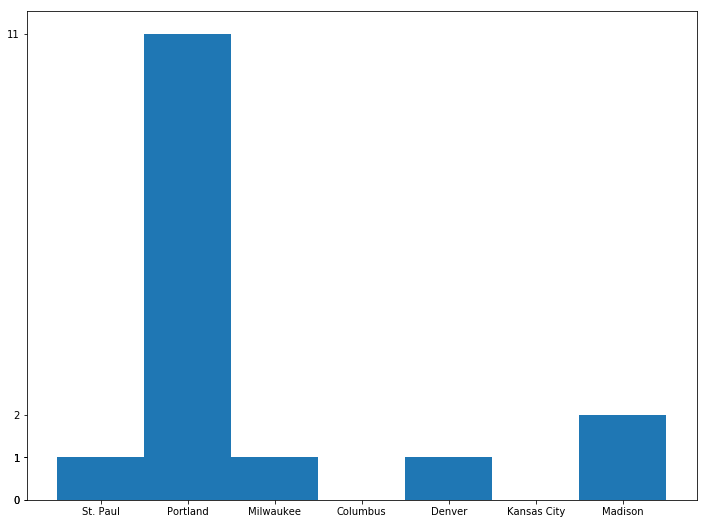

In [19]:
import numpy as np                                                               
import matplotlib.pyplot as plt

city_results=[('St. Paul',1),('Portland',11),('Milwaukee',1), ('Columbus', 0), ('Denver', 1), ('Kansas City', 0), ('Madison', 2)]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
labels, ys = zip(*city_results)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) 
plt.yticks(ys)
plt.show()

As stated in the conclusion, Portland easily won the comparison, but I wanted to have a presentation via a visualization here for a very simple summary.  Something that I did find interesting was that my initial problem statement was proven somewhat by the numbers I found here.

Even though St. Paul had a good number of comic book stores, they are fairly spread out.  The same was true of the similar city Denver.  But Portland is very compact by lookup with the Google Maps API calls.

Also, for clarity, I did not show the raw Google Maps driving time durations.  I am a little worried that this could be seen as a violation of the Google terms of service there so I simplified that data as a binary "with in 10 minutes" true/false type value.  Then counted those values.  I'm hoping that simplifies the city comparison as well.

I wonder if (like most businesses), it is more ideal for comic book stores to not be too close to each other.  If stores are too close they may poach too much business for each other.  This is good for the stores, but not the perfectly ideal scenario for me as I stated in my problem statement.  Again, I wonder if I were to run these numbers on more and more cities if I would see that generally spread out stores, with a few outliers like Portland.